In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install langchain_openai langchain_core langchain-community -q
!pip install -U langgraph
!pip install PyMuPDF python-docx gradio -q

# State 및 라이브러리 임포트

In [28]:
import pandas as pd
import numpy as np
import os
import ast
import fitz  # PyMuPDF
from docx import Document
import random
import openai
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser, CommaSeparatedListOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Dict

class InterviewState(TypedDict):
    resume_text: str
    resume_summary: str
    resume_keywords: List[str]
    question_strategy: Dict[str, Dict]

    # 새 주제 질문의 순서를 추적
    topic_index: int

    current_question: str
    current_answer: str
    current_strategy: str

    # 꼬리 질문 실패 횟수
    follow_up_strikes: int

    conversation: List[Dict[str, str]]
    evaluation : List[Dict[str, str]]
    next_step : str
    current_score : float
    sum_score : float
    count : int
    report : str
    question_dict : dict

def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/KT_Aivle_School/미니프로젝트_02/AI_미니프로젝트 2차_3일차_실습자료/project_genai/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

In [29]:
def extract_text_from_file(file_path: str) -> str:
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".pdf":
        doc = fitz.open(file_path)
        text = "\n".join(page.get_text() for page in doc)
        doc.close()
        return text
    elif ext == ".docx":
        doc = Document(file_path)
        return "\n".join(p.text for p in doc.paragraphs if p.text.strip())
    else:
        raise ValueError("지원하지 않는 파일 형식입니다. PDF 또는 DOCX만 허용됩니다.")

def preProcessing_Interview(file_path: str) -> InterviewState:
    resume_text = extract_text_from_file(file_path)
    input_state: InterviewState = {
        "resume_text": resume_text,
        "resume_summary": '',
        "resume_keywords": [],
        "question_strategy": {},

        # 새로운 전략에 대한 질문 횟수 카운트
        "topic_index": 0,

        "current_question": '',
        "current_answer": '',
        "current_strategy": '',

        # 꼬리 질문에 대한 횟수 카운트
        "follow_up_strikes": 0,

        "conversation": [],
        "evaluation": [],
        "next_step" : '',
        "current_score" : 0.0,
        "sum_score" : 0.0,
        "count" : 0,
        "report" : "",
        "question_dict" : {}
    }
    return input_state

In [30]:
class summary_n_keywords(BaseModel):
    summary: str
    keywords: list

def analyze_resume(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    parser = PydanticOutputParser(pydantic_object=summary_n_keywords)

    prompt = ChatPromptTemplate.from_messages([
        ("system",  "당신은 전문적인 HR recruiter이자 경력 기술 분석가입니다.\n"
                    "지원자의 이력서나 자기소개서 내용을 바탕으로 핵심 내용을 간결하게 요약하고, "
                    "이력서에서 중요도가 높은 키워드를 추출하세요.\n "
                    "추출한 키워드중 중요도가 높은 키워드가 가장 앞으로 나오게 해주세요\n "
                    "객관적이고 중립적인 톤으로 작성하십시오."),
        ("human",   "다음은 지원자의 이력서 및 자기소개서 내용입니다\n"
                    "{resume_text}\n\n"
                    "이 내용을 기반으로 다음 두 가지를 생성해주세요:\n"
                    "1. 3~5문장 내의 핵심 요약 (summary)\n"
                    "2. 5~10개의 핵심 키워드 (keywords)\n"),
        ("system", "{format_instructions}")  # 파서가 제공한 응답 형식 가이드
    ])

    messages = prompt.format_messages(
        resume_text=state["resume_text"],
        format_instructions=parser.get_format_instructions()
    )

    llm = ChatOpenAI(model="gpt-4.1-mini")

    response = llm.invoke(messages)
    parsed = parser.parse(response.content)

    resume_summary = parsed.summary
    resume_keywords = parsed.keywords

    # return 코드는 제공합니다.
    return {
        **state,
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
    }

In [31]:
class question(BaseModel):
    """3개 분야별 질문 전략"""
    strategy: dict = Field(
        description="각 분야(경력 및 경험, 동기 및 커뮤니케이션, 논리적 사고)에 대한 질문 방향과 예시 질문을 담은 딕셔너리"
    )

def generate_question_strategy(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    parser = PydanticOutputParser(pydantic_object=question)

    prompt = ChatPromptTemplate.from_messages([
        ("system",  "너는 채용 면접 코치이다.\n"
                    "지원자의 이력 요약과 주요 키워드를 분석하여 "
                    "3가지 평가 분야(경력 및 경험, 동기 및 커뮤니케이션, 논리적 사고)에 대한 "
                    "맞춤형 질문 전략을 수립하라.\n"
                    "출력은 반드시 JSON 딕셔너리 형태로 생성해야 한다."),
        ("human",   "다음 정보를 참고하여 면접 질문 전략을 만들어라.\n\n"
                    "【핵심 요약】\n{resume_summary}\n\n"
                    "【주요 키워드】\n{resume_keywords}\n\n"
                    "출력 JSON 예시(형식만, 내용은 생성):\n"
                    "{{\n"
                    "  \"strategy\": {{\n"
                    "    \"경력 및 경험\": {{\"질문 방향\": \"...\", \"예시 질문\": [\"...\", \"...\", \"...\"]}},\n"
                    "    \"동기 및 커뮤니케이션\": {{\"질문 방향\": \"...\", \"예시 질문\": [\"...\", \"...\", \"...\"]}},\n"
                    "    \"논리적 사고\": {{\"질문 방향\": \"...\", \"예시 질문\": [\"...\", \"...\", \"...\"]}}\n"
                    "  }}\n"
                    "}}\n"
                    # "질문은 반드시 주요 키워드 중 최소 1개 이상을 포함해야 한다.\n"
                    # "모호하거나 중복된 질문은 금지한다."
                    ),
        ("system", "{format_instructions}")  # 파서가 제공한 응답 형식 가이드
    ])

    messages = prompt.format_messages(
        resume_summary=state["resume_summary"],
        resume_keywords=", ".join(state["resume_keywords"]),
        format_instructions=parser.get_format_instructions()
    )

    llm = ChatOpenAI(model="gpt-4.1-mini")

    response = llm.invoke(messages)
    parsed = parser.parse(response.content)

    strategy_dict = parsed.strategy

    # return 코드는 제공합니다.
    return {
        **state,
        "question_strategy": strategy_dict
    }

In [32]:
class now_question(BaseModel):
    select_quest : dict = Field(
        description="각 분야에 대한 예시 질문중 주요 키워드에서 높은 중요도 보이는 키워드를 가진 선정된 질문 딕셔너리"
    )

def select_question(state: InterviewState) -> InterviewState:
    # selected_question=state["question_strategy"]["경력 및 경험"]["예시 질문"][0]
    #if len(state["question_dict"])==0:
        #parser = PydanticOutputParser(pydantic_object=now_question)
    if not state.get("question_dict") or isinstance(state["question_dict"], dict):
        parser = PydanticOutputParser(pydantic_object=now_question)

        prompt = ChatPromptTemplate.from_messages([
            ("system",  "너는 채용 면접 코치이다.\n"
                        "각 분야의 예상질문들과 키워드 중요도를 파악하여"
                        "높은 중요도를 보이는 키워드를 가진 각 분야별 질문을 선정해라.\n"
                        "출력은 반드시 JSON 딕셔너리 형태로 생성해야 한다."),
            ("human",   "다음 정보를 참고하여 면접 질문 전략을 만들어라.\n\n"
                        "【예상 질문】\n{question_strategy}\n\n"
                        "【주요 키워드】\n{resume_keywords}\n\n"
                        "출력 JSON 예시(형식만, 내용은 생성):\n"
                        "{{\n"
                        "  \"select_quest\": {{\n"
                        # "  \"question\": {{\n"
                        "    \"경력 및 경험\": {{\"선정 질문\": \"...\"}},\n"
                        "    \"동기 및 커뮤니케이션\": {{\"선정 질문\": \"...\"}},\n"
                        "    \"논리적 사고\": {{\"선정 질문\": \"...\"]}},\n"
                        "    \"기술 서술\": {{\"선정 질문\": \"...\"]}},\n"
                        "  }}\n"
                        "}}\n"

                        ),
            ("system", "{format_instructions}")  # 파서가 제공한 응답 형식 가이드
        ])

        messages = prompt.format_messages(
            question_strategy=state["question_strategy"],
            resume_keywords=", ".join(state["resume_keywords"]),
            format_instructions=parser.get_format_instructions()
        )

        llm = ChatOpenAI(model="gpt-4.1-mini")

        response = llm.invoke(messages)
        parsed = parser.parse(response.content)

        # 딕셔너리가 아닌 '리스트'로 저장
        state["question_dict"] = list(parsed.select_quest.items())
        state["topic_index"] = 0 # 인덱스 0으로 초기화

        """
        question_dict = parsed.select_quest
        state["question_dict"]=question_dict.items()

    temp=iter(state["question_dict"])
    temp_count=state["count"]+1
    if temp_count>3: temp_count=3
    for i in range(temp_count):
        current_subject, current_question = next(temp)
    current_question=current_question["선정 질문"]

    return {
            **state,
            "current_question": current_question,
            "current_strategy": current_subject
            }
        """
#  count 대신 topic_index를 사용
    topic_index = state["topic_index"]
    question_list = state["question_dict"] # state["question_dict"] 리스트

    #  질문 리스트의 끝에 도달했는지 확인
    if topic_index >= len(question_list):
        # 더 이상 질문할 새 주제가 없으므로 종료 신호
        return {
            **state,
            "next_step": "force_end" # 강제 종료 신호
        }

    #  topic_index로 현재 질문 선택
    current_subject, current_question_data = question_list[topic_index]
    current_question = current_question_data["선정 질문"]

    return {
            **state,
            "current_question": current_question,
            "current_strategy": current_subject,
            "topic_index": topic_index + 1, # 다음 새 주제를 위해 인덱스 1 증가
            "follow_up_strikes": 0  #  새 주제가 시작되므로 스트라이크 리셋
            }


In [33]:
def input_answer(state: InterviewState) -> InterviewState:
    print("\n[질문]")
    print(state["current_question"])
    state["current_answer"] = input("\n[답변 입력]:\n")
    return state

class eval_answer(BaseModel):
    evaluation: List[Dict[str, int]] = Field(
        description="예: [{'1. 질문과의 관련성': 5}, {'2. 답변의 구체성': 3}]"
    )
    score: int = Field(
        description="총점 (0-25점). 각 평가 항목의 점수를 종합한 결과"
    )
    weak_points: List[str] = Field(
        description="부족한 부분 목록. 점수가 낮은 항목이나 보완이 필요한 영역"
    )

def evaluate_answer(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    parser = PydanticOutputParser(pydantic_object=eval_answer)

    prompt = ChatPromptTemplate.from_messages([
        ("system", "너는 채용 면접 코치다. 지원자의 답변을 평가하고 점수를 매겨라.\n"
                   "반드시 JSON만 출력한다."),
        ("human",  "【맥락 요약】\n"
                   "- 이력 요약: {resume_summary}\n"
                   "- 주요 키워드: {resume_keywords}\n"
                   "- 현재 질문전략: {current_strategy}\n"
                   "【평가 대상】\n"
                   "- 질문: {current_question}\n"
                   "- 답변: {current_answer}\n\n"
                   "【평가 기준 및 등급 가이드】\n"
                   "1) '1. 질문과의 관련성' (1-5점):\n"
                   "   - 상(5): 질문 핵심 의도를 완전히 포착, 요구사항 전부를 정확히 다름\n"
                   "   - 상중(4): 핵심 의도는 정확히 파악, 부차 항목 일부 미흡\n"
                   "   - 중(3): 관련 있으나 핵심 포인트 일부 누락/부정확 \n"
                   "   - 중하(2): 주변 맥락 위주로 빗나감, 핵심 연결 약함 \n"
                   "   - 하(1): 무관/엉뚱한 내용 중심 \n"
                   "2) '2. 답변의 구체성' (1-5점):\n"
                   "   - 상(5): 수치/지표/기간/규모/역할/결과 등 STAR형 근거 제시\n"
                   "   - 상중(4): 사례•지표 있으나 일부 모호/누락 \n"
                   "   - 중(3): 일반론 위주, 근거 부족 \n"
                   "   - 중하(2): 추상적 진술 대부분, 근거 빈약 \n"
                   "   - 하(1): 근거•사실 관측 불가 \n"
                   "3) '3. 논리적 일관성' (1-5점)\n"
                   "   - 상(5): 주장+근거+결론 흐름 일관, 반례/제약 인지 \n"
                   "   - 상중(4): 전반 타당, 일부 연결 약함 \n"
                   "   - 중(3): 비약/빈칸 존재 \n"
                   "   - 중하(2): 모순/전개 불명확 \n"
                   "   - 하(1): 논리 전개 부재 \n"
                   "4) '4. 커뮤니케이션 명확성' (1-5점)\n"
                   "   - 상(5): 간결•정돈, 중요도 순•용어 일관, 오해 소지 없음 \n"
                   "   - 상중(4): 전반 명확, 일부 장황/중복 \n"
                   "   - 중(3): 핵심 전달은 되나 장황/혼재 \n"
                   "   - 중하(2): 핵심 파악 어려움 \n"
                   "   - 하(1): 이해 곤란 \n"
                   "5) '5. 실무 임팩트/성과' (1-5점)\n"
                   "   - 상: 조직/사업 KPI에 직접적• 측정 가능한 성과 \n"
                   "   - 상중(4): 정량 성과/질적 개선 존재하나 범위•지속성 일부 제한 \n"
                   "   - 중(3): 개선 시도와 결과는 있으나 정량 근거/영향 범위 불분명 \n"
                   "   - 중하(2): 개인 학습/시도 수준에 머물고 조직적 임팩트 낮음 \n"
                   "   - 하(1): 성과/임팩트 근거 제시 없음 \n"
                   "※ 총점(score)은 위 5개 항목의 점수를 합산하여 0-25점으로 계산\n"
                   "※ weak_points는 점수가 낮은(중/하) 항목과 구체적 보완사항을 리스트로 제공\n"),
        ("system", "{format_instructions}")  # 파서가 제공한 응답 형식 가이드
    ])

    messages = prompt.format_messages(
        resume_summary=state["resume_summary"],
        resume_keywords=", ".join(state["resume_keywords"]),
        current_strategy=state["current_strategy"],
        current_question=state["current_question"],
        current_answer=state["current_answer"],
        format_instructions=parser.get_format_instructions()
    )

    llm = ChatOpenAI(model="gpt-4.1-mini")

    response = llm.invoke(messages)
    parsed = parser.parse(response.content)

    scores = [score for item in parsed.evaluation for score in item.values()]
    current_score = sum(scores) / len(scores) if scores else 0  # 1-5점 범위의 평균


    conversation = state["conversation"]
    conversation.append({
        f"{state['count']}. 질문": state['current_question'],
        f"{state['count']}. 답변": state['current_answer'],
        f"{state['count']}. 평가": parsed.evaluation,
        f"{state['count']}. 점수": round(current_score, 2),
        f"{state['count']}. 부족한 부분": parsed.weak_points
    })

    return {
        **state,
        "evaluation": parsed.evaluation,
        "current_score": current_score,
        "conversation": conversation,
    }

In [37]:
def decide_next_step(state: InterviewState) -> InterviewState:
    # select_question에서 보낸 강제 종료 신호 확인
    if state.get("next_step") == "force_end":
        return {**state, "next_step": "end"}

    # count는 꼬리질문 포함 총 턴 수
    state["count"]+=1
    current_score = state.get("current_score", 0)
    state["sum_score"] += current_score


    avg_score = state["sum_score"] / state["count"]

    # 현재 꼬리 질문 스트라이크 횟수
    follow_up_strikes = state.get("follow_up_strikes", 0)

    # else: 블록 제거하고 점수 로직만 남김
    if state["count"] == 1 and current_score <= 2:
        next_step = "follow-up_question"
    elif current_score <= 2 and not avg_score > 2.9:
        next_step = "end" # (요청사항) 점수가 낮으면 즉시 종료 (유지)
    elif 2 < current_score < 3.5:
        next_step = "follow-up_question"
    else:
        next_step = "new_topic_question"

    # 스트라이크 아웃 로직
    if next_step == "follow-up_question":
        follow_up_strikes += 1  # 꼬리 질문이 결정되면 스트라이크 1 증가
        if follow_up_strikes >= 2:
            print("\n[SYSTEM] 꼬리 질문 점수 미달이 2회 누적되어 면접을 종료합니다.")
            next_step = "end"  # 스트라이크가 2가 되면 강제 종료

    # 새 주제로 가야 하는데, 더 이상 주제가 없는지 확인
    topic_index = state["topic_index"]
    # state["question_dict"]가 리스트(list)가 되었으므로 len() 사용
    num_topics = len(state.get("question_dict", []))

    if next_step == "new_topic_question" and topic_index >= num_topics:
        # 새 주제로 가야하는데, 주제가 바닥나면 종료
        next_step = "end"


    return {
        **state,
        "next_step": next_step,
        "follow_up_strikes": follow_up_strikes
    }


class additional_q(BaseModel):
    deepen_q: str = Field(
        description="지원자의 사고력/문제해결/기술적 깊이를 검증하는 심화 질문 한 문장"
    )

def generate_question(state: InterviewState) -> InterviewState:

    parser = PydanticOutputParser(pydantic_object=additional_q)

    prompt = ChatPromptTemplate.from_messages([
        ("system",  "너는 채용 면접 코치다. 아래 정보를 바탕으로 ‘이전 답변’을 검토한 후 "
                    "지원자의 사고력·문제해결 방식·기술적 깊이를 더 확인할 수 있는 "
                    "심화 인터뷰 질문 1개만 생성하라. 반드시 JSON으로만 답하라.\n"),
        ("human",   "【이력서 요약】\n{resume_summary}\n\n"
                    "【주요 키워드】\n{resume_keywords}\n\n"
                    "【현재 질문전략(있다면)】\n{current_strategy}\n\n"
                    "【이전 질문】\n{prev_q}\n\n"
                    "【이전 답변】\n{prev_a}\n\n"
                    "【평가 결과(상/중/하 목록)】\n{eval_list}\n\n"
                    "요구사항:\n"
                    "- 이전 답변의 빈약하거나 모호했던 지점(예: 근거 부족, 수치/지표 부재, 실패원인 분석 부족, 대안 비교 미흡)을 겨냥해 한 단계 파고드는 질문을 만들어라.\n"
                    "- 가능한 한 구체적 근거(수치·지표·실험 설계·의사결정 기준·트레이드오프)를 끌어내도록 설계하라.\n"
                    "- 유사 질문/중복 질문 금지. 한 문장, 존댓말, 한국어. ‘왜/어떻게/무엇을 기준으로’ 같은 탐색형 접두를 활용하라.\n"
                    "- 답변을 유도하는 힌트나 예시는 넣지 말고, 질문만 출력하라."
                    ),
        ("system", "{format_instructions}")
    ])

    messages = prompt.format_messages(
        resume_summary=state["resume_summary"],
        resume_keywords=", ".join(state["resume_keywords"]),
        current_strategy=state["current_strategy"],
        prev_q=state["current_question"],
        prev_a=state["current_answer"],
        eval_list=str(state["evaluation"]),
        format_instructions=parser.get_format_instructions()
    )

    llm = ChatOpenAI(model="gpt-4.1-mini")

    response = llm.invoke(messages)
    parsed = parser.parse(response.content)

    add_q = parsed.deepen_q


    return {
        **state,
        "current_question": add_q,
        "current_answer": ""
    }

In [38]:
def summarize_interview(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    conversation=state["conversation"]
    conversation_text=""
    for i, turn in enumerate(conversation):
        q = turn.get(f"{i}. 질문", "")
        a = turn.get(f"{i}. 답변", "")

        eval_list = turn.get(f"{i}. 평가", [])
        eval_text = ", ".join(f"{k}: {v}" for e in eval_list for k, v in e.items())
        week_list = turn.get(f"{i}. 부족한 부분", [])
        week_text = ", ".join(week_list)

        conversation_text += (
            f"\n[{i}번째 질문 세트]\n"
            f"질문: {q}\n"
            f"답변: {a}\n"
            f"평가: {eval_text}\n"
            f"부족한 부분: {week_text}\n"
        )

    report = conversation_text

    # return 코드는 제공합니다.
    return {
        **state,
        "report": report
    }

In [39]:
def route_next(state: InterviewState) -> Literal["generate_question", "select_question", "summarize_interview"]:
    next_step=state["next_step"]
    if next_step=="follow-up_question": return "generate_question"
    elif next_step=="new_topic_question": return "select_question"
    else: return "summarize_interview"

def wrap_node(name, fn):
    def _wrapped(state, *a, **k):
        print(f"[NODE START] {name}")
        try:
            out = fn(state, *a, **k)
            print(f"[NODE DONE]  {name}")
            return out
        except Exception as e:
            # 여기서 정확한 노드명을 보고 원인을 잡을 수 있음
            print(f"[NODE ERROR] {name} -> {type(e).__name__}: {e}")
            raise
    return _wrapped

builder = StateGraph(InterviewState)

debug_bool=False
if debug_bool:
    builder.add_node("analyze_resume", wrap_node("analyze_resume", analyze_resume))
    builder.add_node("generate_question_strategy", wrap_node("generate_question_strategy", generate_question_strategy))
    builder.add_node("select_question", wrap_node("select_question", select_question))
    builder.add_node("input_answer", wrap_node("input_answer", input_answer))
    builder.add_node("evaluate_answer", wrap_node("evaluate_answer", evaluate_answer))
    builder.add_node("decide_next_step", wrap_node("decide_next_step", decide_next_step))
    builder.add_node("generate_question", wrap_node("generate_question", generate_question))
    builder.add_node("summarize_interview", wrap_node("summarize_interview", summarize_interview))
else:
    builder.add_node("analyze_resume", analyze_resume)
    builder.add_node("generate_question_strategy", generate_question_strategy)
    builder.add_node("select_question", select_question)
    builder.add_node("input_answer", input_answer)

    builder.add_node("evaluate_answer", evaluate_answer)
    builder.add_node("decide_next_step", decide_next_step)
    builder.add_node("generate_question", generate_question)
    builder.add_node("summarize_interview", summarize_interview)


builder.add_edge(START, "analyze_resume")
builder.add_edge("analyze_resume", "generate_question_strategy")
builder.add_edge("generate_question_strategy", "select_question")

builder.add_edge("select_question", "input_answer")
builder.add_edge("input_answer", "evaluate_answer")
builder.add_edge("evaluate_answer", "decide_next_step")

builder.add_conditional_edges("decide_next_step", route_next)
builder.add_edge("generate_question", "input_answer")


builder.add_edge("summarize_interview", END)


graph = builder.compile()

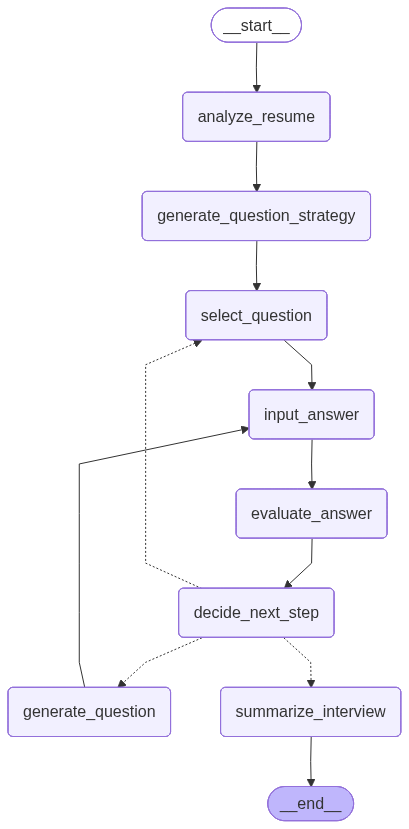

In [40]:
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
file_path = "/content/drive/MyDrive/KT_Aivle_School/미니프로젝트_02/AI_미니프로젝트 2차_3일차_실습자료/Resume_sample.pdf"
input_state=preProcessing_Interview(file_path)
output_state=graph.invoke(input_state)
output_state["report"]


[질문]
KT AI 연구소 인턴 기간 중 담당했던 OCR 고도화 프로젝트에서 가장 어려웠던 기술적 문제는 무엇이며, 어떻게 해결했나요?

[답변 입력]:
“가장 어려웠던 문제는 한글 혼용 문서에서 저해상도·기울어짐·전각/반각 혼재로 인해 인식이 들쑥날쑥했고, 그 결과 필드 단위 정확도가 불안정했던 점이었습니다. 저는 모델만 바꾸기보다 ‘데이터–모델–후처리–서빙’을 한 번에 안정화하는 전략으로 접근했습니다: 먼저 실사용 로그를 모아 오탐 Top 케이스를 유형화하고, detection IoU와 recognition CER를 분리해 원인을 진단했으며, 불확실도 기반 액티브 러닝으로 의심 샘플을 선별해 라벨 품질을 보정하고 전각/반각·특수문자·왜곡을 반영한 증강 프로파일을 추가했습니다. 모델 측면에선 DB 계열 검출을 경량 재학습해 FP를 줄이고, 인식기는 한글 자모 정규화와 Temperature Scaling으로 칼리브레이션을 맞춘 뒤 도메인 사전+경량 LM re-ranking으로 고유명사/전문용어를 보강했습니다. 필드 레벨에선 날짜·금액·사업자번호에 정규식/체크섬 검증을 걸어 잔여 오류를 차단했고, 스트림 환경에서는 EMA 스무딩·히스테리시스 임계·최소 지속시간을 적용해 챠터링을 제거했습니다. 서빙은 ONNX/TensorRT·동적 배치·비동기 파이프라인으로 병목을 해소하고, 백프레셔/idemopotency와 카나리 배포·관측가능성(로그/메트릭/트레이싱)을 표준화했습니다. 그 결과 필드 정확도와 안정성이 눈에 띄게 개선되고 피크 구간의 재시도율·지연 분포가 안정돼, 사용자 체감 품질을 실제 운영에서 끌어올린 것이 핵심 성과였습니다.”

[질문]
코드 리뷰 과정에서 받았던 피드백 중 가장 인상 깊었던 점과 그 피드백을 코드에 어떻게 반영했는지 설명해 주세요.

[답변 입력]:
음… 코드 리뷰에서 “함수 길이가 너무 길다”는 피드백이 기억에 남습니다. 그래서 큰 함수 몇 개를 둘로 나누고 변수 이름도 조금 정리했어요. 테스트는 따로 손대진 않았고, 구조 자체를 바꾸거

'\n[0번째 질문 세트]\n질문: KT AI 연구소 인턴 기간 중 담당했던 OCR 고도화 프로젝트에서 가장 어려웠던 기술적 문제는 무엇이며, 어떻게 해결했나요?\n답변: “가장 어려웠던 문제는 한글 혼용 문서에서 저해상도·기울어짐·전각/반각 혼재로 인해 인식이 들쑥날쑥했고, 그 결과 필드 단위 정확도가 불안정했던 점이었습니다. 저는 모델만 바꾸기보다 ‘데이터–모델–후처리–서빙’을 한 번에 안정화하는 전략으로 접근했습니다: 먼저 실사용 로그를 모아 오탐 Top 케이스를 유형화하고, detection IoU와 recognition CER를 분리해 원인을 진단했으며, 불확실도 기반 액티브 러닝으로 의심 샘플을 선별해 라벨 품질을 보정하고 전각/반각·특수문자·왜곡을 반영한 증강 프로파일을 추가했습니다. 모델 측면에선 DB 계열 검출을 경량 재학습해 FP를 줄이고, 인식기는 한글 자모 정규화와 Temperature Scaling으로 칼리브레이션을 맞춘 뒤 도메인 사전+경량 LM re-ranking으로 고유명사/전문용어를 보강했습니다. 필드 레벨에선 날짜·금액·사업자번호에 정규식/체크섬 검증을 걸어 잔여 오류를 차단했고, 스트림 환경에서는 EMA 스무딩·히스테리시스 임계·최소 지속시간을 적용해 챠터링을 제거했습니다. 서빙은 ONNX/TensorRT·동적 배치·비동기 파이프라인으로 병목을 해소하고, 백프레셔/idemopotency와 카나리 배포·관측가능성(로그/메트릭/트레이싱)을 표준화했습니다. 그 결과 필드 정확도와 안정성이 눈에 띄게 개선되고 피크 구간의 재시도율·지연 분포가 안정돼, 사용자 체감 품질을 실제 운영에서 끌어올린 것이 핵심 성과였습니다.”\n평가: 1. 질문과의 관련성: 5, 2. 답변의 구체성: 5, 3. 논리적 일관성: 5, 4. 커뮤니케이션 명확성: 4, 5. 실무 임팩트/성과: 5\n부족한 부분: 4. 커뮤니케이션 명확성: 답변이 전반적으로 명확했으나, 일부 기술적인 디테일이 장황하여 감점됨. 이러한 부분은 더 간결하게 표현될 필요가 있음.\n\

In [52]:
print(output_state["report"])


[0번째 질문 세트]
질문: KT AI 연구소 인턴 기간 중 담당했던 OCR 고도화 프로젝트에서 가장 어려웠던 기술적 문제는 무엇이며, 어떻게 해결했나요?
답변: “가장 어려웠던 문제는 한글 혼용 문서에서 저해상도·기울어짐·전각/반각 혼재로 인해 인식이 들쑥날쑥했고, 그 결과 필드 단위 정확도가 불안정했던 점이었습니다. 저는 모델만 바꾸기보다 ‘데이터–모델–후처리–서빙’을 한 번에 안정화하는 전략으로 접근했습니다: 먼저 실사용 로그를 모아 오탐 Top 케이스를 유형화하고, detection IoU와 recognition CER를 분리해 원인을 진단했으며, 불확실도 기반 액티브 러닝으로 의심 샘플을 선별해 라벨 품질을 보정하고 전각/반각·특수문자·왜곡을 반영한 증강 프로파일을 추가했습니다. 모델 측면에선 DB 계열 검출을 경량 재학습해 FP를 줄이고, 인식기는 한글 자모 정규화와 Temperature Scaling으로 칼리브레이션을 맞춘 뒤 도메인 사전+경량 LM re-ranking으로 고유명사/전문용어를 보강했습니다. 필드 레벨에선 날짜·금액·사업자번호에 정규식/체크섬 검증을 걸어 잔여 오류를 차단했고, 스트림 환경에서는 EMA 스무딩·히스테리시스 임계·최소 지속시간을 적용해 챠터링을 제거했습니다. 서빙은 ONNX/TensorRT·동적 배치·비동기 파이프라인으로 병목을 해소하고, 백프레셔/idemopotency와 카나리 배포·관측가능성(로그/메트릭/트레이싱)을 표준화했습니다. 그 결과 필드 정확도와 안정성이 눈에 띄게 개선되고 피크 구간의 재시도율·지연 분포가 안정돼, 사용자 체감 품질을 실제 운영에서 끌어올린 것이 핵심 성과였습니다.”
평가: 1. 질문과의 관련성: 5, 2. 답변의 구체성: 5, 3. 논리적 일관성: 5, 4. 커뮤니케이션 명확성: 4, 5. 실무 임팩트/성과: 5
부족한 부분: 4. 커뮤니케이션 명확성: 답변이 전반적으로 명확했으나, 일부 기술적인 디테일이 장황하여 감점됨. 이러한 부분은 더 간결하게 표현될 필요가 있음.

[1번째 질문

In [53]:
print(output_state["conversation"])

[{'0. 질문': 'KT AI 연구소 인턴 기간 중 담당했던 OCR 고도화 프로젝트에서 가장 어려웠던 기술적 문제는 무엇이며, 어떻게 해결했나요?', '0. 답변': '“가장 어려웠던 문제는 한글 혼용 문서에서 저해상도·기울어짐·전각/반각 혼재로 인해 인식이 들쑥날쑥했고, 그 결과 필드 단위 정확도가 불안정했던 점이었습니다. 저는 모델만 바꾸기보다 ‘데이터–모델–후처리–서빙’을 한 번에 안정화하는 전략으로 접근했습니다: 먼저 실사용 로그를 모아 오탐 Top 케이스를 유형화하고, detection IoU와 recognition CER를 분리해 원인을 진단했으며, 불확실도 기반 액티브 러닝으로 의심 샘플을 선별해 라벨 품질을 보정하고 전각/반각·특수문자·왜곡을 반영한 증강 프로파일을 추가했습니다. 모델 측면에선 DB 계열 검출을 경량 재학습해 FP를 줄이고, 인식기는 한글 자모 정규화와 Temperature Scaling으로 칼리브레이션을 맞춘 뒤 도메인 사전+경량 LM re-ranking으로 고유명사/전문용어를 보강했습니다. 필드 레벨에선 날짜·금액·사업자번호에 정규식/체크섬 검증을 걸어 잔여 오류를 차단했고, 스트림 환경에서는 EMA 스무딩·히스테리시스 임계·최소 지속시간을 적용해 챠터링을 제거했습니다. 서빙은 ONNX/TensorRT·동적 배치·비동기 파이프라인으로 병목을 해소하고, 백프레셔/idemopotency와 카나리 배포·관측가능성(로그/메트릭/트레이싱)을 표준화했습니다. 그 결과 필드 정확도와 안정성이 눈에 띄게 개선되고 피크 구간의 재시도율·지연 분포가 안정돼, 사용자 체감 품질을 실제 운영에서 끌어올린 것이 핵심 성과였습니다.”', '0. 평가': [{'1. 질문과의 관련성': 5}, {'2. 답변의 구체성': 5}, {'3. 논리적 일관성': 5}, {'4. 커뮤니케이션 명확성': 4}, {'5. 실무 임팩트/성과': 5}], '0. 점수': 4.8, '0. 부족한 부분': ['4. 커뮤니케이션 명확성: 답변이 전반적으로 명확했으나, 일부 기